# The outflow bank customers

## Introduction

Customers began to leave the bank every month. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. We have historical data on the behavior of customers and the termination of contracts with the bank. 

We need to build a model with an extremely large value of *F1*-measures. 

Additionally measure *AUC-ROC*, compare its value with *F1*-measure.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


## Preprocessing data

In [1]:
!pip install -U lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 42
warnings.filterwarnings("ignore")
plt.style.use('dark_background')

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Get rid of useless features

In [7]:
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

### Check duplicates and missing value

In [8]:
df.duplicated().sum(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


(0, None)

In [9]:
df.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [10]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


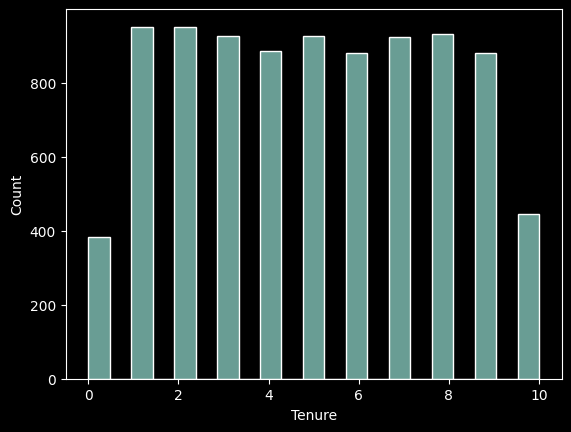

In [11]:
sns.histplot(df['Tenure']);

We have missing values in column "Tenure", change them median with the help of SimpleImputer in Pipeline

interval columns not set, guessing: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


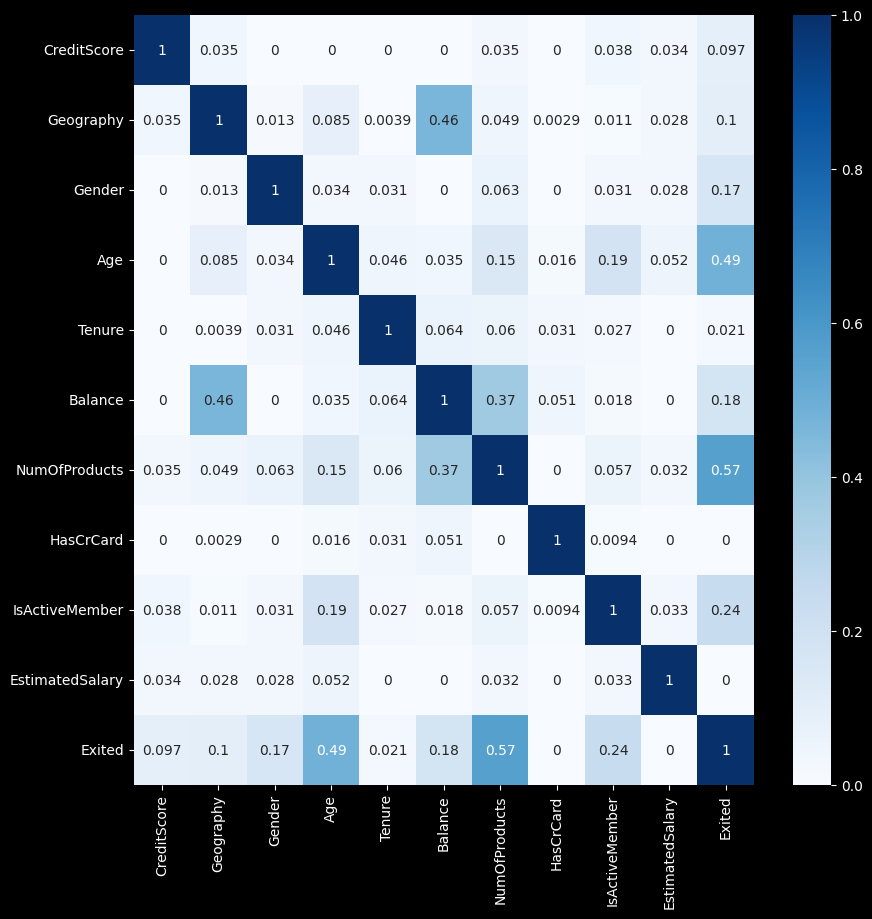

In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.phik_matrix(), cmap='Blues', annot=True);

Multicollinearity was not detected. We also see that functions such as "HasCrCard" and "EstimatedSalary" have no correlation with the target function. Delete them.

### Preparing features

Split dataframe into two sample

In [13]:
X = df.drop(['Exited', 'HasCrCard', 'EstimatedSalary'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=RANDOM_STATE)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 8), (2000, 8), (8000,), (2000,))

Some features such as "HasCrCard" and "IsActiveMember" are categorical binary features, so we don't need encode them.

In [15]:
cat_features = X.select_dtypes(include='object').columns.to_list()
num_features = X.select_dtypes(exclude='object').columns.to_list()
num_features.remove('IsActiveMember')

In [16]:
X[num_features], X[cat_features]

(      CreditScore  Age  Tenure    Balance  NumOfProducts
 0             619   42     2.0       0.00              1
 1             608   41     1.0   83807.86              1
 2             502   42     8.0  159660.80              3
 3             699   39     1.0       0.00              2
 4             850   43     2.0  125510.82              1
 ...           ...  ...     ...        ...            ...
 9995          771   39     5.0       0.00              2
 9996          516   35    10.0   57369.61              1
 9997          709   36     7.0       0.00              1
 9998          772   42     3.0   75075.31              2
 9999          792   28     NaN  130142.79              1
 
 [10000 rows x 5 columns],
      Geography  Gender
 0       France  Female
 1        Spain  Female
 2       France  Female
 3       France  Female
 4        Spain  Female
 ...        ...     ...
 9995    France    Male
 9996    France    Male
 9997    France  Female
 9998   Germany    Male
 9999    Fr

In [17]:
y_train.value_counts(normalize=True)

0    0.79625
1    0.20375
Name: Exited, dtype: float64

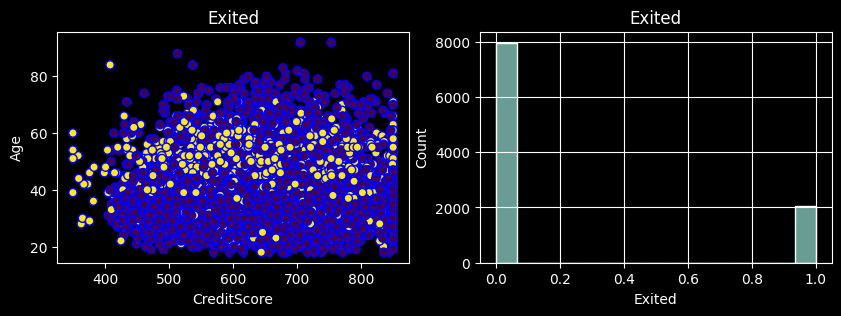

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.scatter(X_train['CreditScore'], X_train['Age'], c=y_train, edgecolors='b')
ax1.set_xlabel('CreditScore')
ax1.set_ylabel('Age')
ax1.set_title('Exited')
plt.grid()

sns.histplot(y, ax=ax2)
ax2.set_title('Exited');

There is an imbalance of classes in the training sample. We will investigate several models and check the effect of the imbalance on the quality of prediction.

## Models Building

**Create function for searching the best model**

In [19]:
# pipline for transforming columns
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [20]:
def clf_models(X_train, y_train, resampling=None, class_weight: str = None, class_weight_catboost: str = None):
    models = []

    # LogisticRegression
    X_train_lr = X_train.copy()
    y_train_lr = y_train.copy()

    pipline_lr = Pipeline(
        [("resamling", resampling),
         ("preprocessor", preprocessor),
         ("lr", LogisticRegression(class_weight=class_weight, random_state=RANDOM_STATE))])

    param_lr = {"lr__C": np.logspace(-5, 5, 11), }
    grid_lr = GridSearchCV(pipline_lr, param_grid=param_lr,
                           scoring='f1', cv=5, n_jobs=-1)
    grid_lr.fit(X_train_lr, y_train_lr)
    best_result_lr = pd.DataFrame(
        grid_lr.cv_results_).sort_values('rank_test_score').head(1)
    best_result_lr = best_result_lr[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_lr.best_estimator_)

    # LGBMClassifier
    X_train_lgbm = X_train.copy()
    y_train_lgbm = y_train.copy()

    pipline_lgbm = Pipeline(
        [("resamling", resampling),
         ("preprocessor", preprocessor),
         ("lgbm", LGBMClassifier(class_weight=class_weight, random_state=RANDOM_STATE))])

    param_lgbm = {'lgbm__max_depth': [3, 5, 7],
                  'lgbm__n_estimators': [1000, 2000, 3000]}
    grid_lgbm = GridSearchCV(
        pipline_lgbm, param_grid=param_lgbm, scoring='f1', cv=5, n_jobs=-1)
    grid_lgbm.fit(X_train_lgbm, y_train_lgbm)
    best_result_lgbm = pd.DataFrame(
        grid_lgbm.cv_results_).sort_values('rank_test_score').head(1)
    best_result_lgbm = best_result_lgbm[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_lgbm.best_estimator_)

    # CatBoostClassifier
    X_train_cb = X_train.copy()
    y_train_cb = y_train.copy()

    pipline_cb = Pipeline(
        [("resamling", resampling),
         ("preprocessor", preprocessor),
         ("cb", CatBoostClassifier(auto_class_weights=class_weight_catboost, random_state=RANDOM_STATE, verbose=False))])

    param_cb = {'cb__max_depth': [3, 5, 7],
                'cb__n_estimators': [1000, 2000, 3000]}
    grid_cb = GridSearchCV(pipline_cb, param_grid=param_cb,
                           scoring='f1', cv=5, n_jobs=-1)
    grid_cb.fit(X_train_cb, y_train_cb)
    best_result_cb = pd.DataFrame(
        grid_cb.cv_results_).sort_values('rank_test_score').head(1)
    best_result_cb = best_result_cb[[
        'mean_fit_time', 'params', 'mean_test_score']]
    models.append(grid_cb.best_estimator_)

    # result
    result = pd.concat([best_result_lr, best_result_lgbm, best_result_cb])
    result.index = ['LogisticRegression',
                    'LGBMClassifier', 'CatBoostClassifier']
    display(result)
    return models

### Default sample

Training the model on the data without changes

In [21]:
general_models = clf_models(X_train, y_train)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.111775,{'lr__C': 1.0},0.317076
LGBMClassifier,1.091980,"{'lgbm__max_depth': 3, 'lgbm__n_estimators': 1...",0.588499
CatBoostClassifier,8.868701,"{'cb__max_depth': 5, 'cb__n_estimators': 2000}",0.593013


According training results we can see that the best result of metric f1 isn't higher then 0.57. Let's try conducting work with imbalance.

## Solving imbalanced classes

### Oversampling

In [22]:
ros = RandomOverSampler(random_state=RANDOM_STATE)

In [23]:
models_ros = clf_models(X_train, y_train, ros)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.066001,{'lr__C': 0.001},0.501713
LGBMClassifier,0.902785,"{'lgbm__max_depth': 3, 'lgbm__n_estimators': 1...",0.594261
CatBoostClassifier,25.571475,"{'cb__max_depth': 5, 'cb__n_estimators': 3000}",0.609340


We got better results. Let's go on

### Undersampling

In [24]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)

In [25]:
models_rus = clf_models(X_train, y_train, rus)

,mean_fit_time,params,mean_test_score
LogisticRegression,0.036524,{'lr__C': 0.01},0.499254
LGBMClassifier,0.411590,"{'lgbm__max_depth': 3, 'lgbm__n_estimators': 1...",0.568215
CatBoostClassifier,1.861103,"{'cb__max_depth': 3, 'cb__n_estimators': 1000}",0.604386


Undersampling method looks worse, perhaps we lack volume of data.

### Weighting the classes

In [26]:
models_class_weight = clf_models(X_train, y_train, class_weight='balanced', class_weight_catboost='Balanced')

,mean_fit_time,params,mean_test_score
LogisticRegression,0.040164,{'lr__C': 0.01},0.499568
LGBMClassifier,0.642695,"{'lgbm__max_depth': 3, 'lgbm__n_estimators': 1...",0.601042
CatBoostClassifier,3.760881,"{'cb__max_depth': 3, 'cb__n_estimators': 1000}",0.614085


Weighting classes method didn't show us outstanding results. Let's look on test results

## Test models

In [27]:
default = []
oversampling = []
undersampling = []
class_weight = []

# Fuction for getting test results


def test_result(models, result_list):
    for model in models:
        result_list.append(f1_score(y_test, model.predict(X_test)))
    return result_list


default = test_result(general_models, default)
oversampling = test_result(models_ros, oversampling)
undersampling = test_result(models_rus, undersampling)
class_weight = test_result(models_class_weight, class_weight)

test_result_df = pd.DataFrame({'Models': [type(i[2]).__name__ for i in general_models],
                               'Default': default,
                               'Oversampling': oversampling,
                               'Undersampling': undersampling,
                               'class_weight': class_weight})
test_result_df

,Models,Default,Oversampling,Undersampling,class_weight
0,LogisticRegression,0.287313,0.509769,0.500870,0.511013
1,LGBMClassifier,0.594828,0.608225,0.576177,0.610879
2,CatBoostClassifier,0.597243,0.627119,0.614653,0.615385


Let's see which features most influenced the training of the model.

In [28]:
preprocessor.fit(X_train)
feature_importance = pd.DataFrame({'Features': preprocessor.get_feature_names_out(),
                                   'Importance': models_class_weight[2][2].feature_importances_}).sort_values('Importance', ascending=False)
feature_importance

,Features,Importance
4,NumOfProducts,36.358430
1,Age,26.503259
3,Balance,11.403282
10,IsActiveMember,7.958974
6,Geography_Germany,6.814760
0,CreditScore,6.432451
2,Tenure,1.672665
8,Gender_Female,1.086197
9,Gender_Male,0.962850
7,Geography_Spain,0.434443


We can see that oversampling and undersampling gave us better scores then while training, this indicates that the models is underfitted. So, the best result was got with the help CatBoostClassifier with auto_class_weight method.

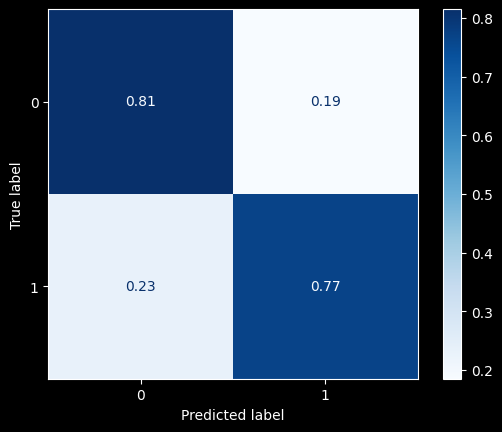

In [29]:
ConfusionMatrixDisplay.from_estimator(
    models_class_weight[2], X_test, y_test, normalize='true', colorbar=True, cmap='Blues');

With the help of the confusion matrix we see that only 77% of client, who left, was detected correctly.  Check it with AUC-ROC.

### AUC-ROC of the best model

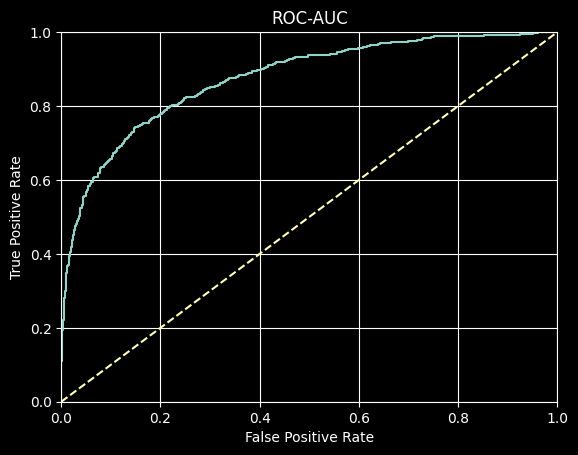

In [30]:
probabilities_test = models_class_weight[2].predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.title("ROC-AUC")

plt.show()

In [31]:
roc_auc_score(y_test, probabilities_one_test)

0.8748640782539088

Let's find the difference between TPR and FPR at different thresholds.

In [32]:
df_roc = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
df_roc['tpr - fpr'] = df_roc['tpr'] - df_roc['fpr']
df_roc.sort_values('tpr - fpr', ascending=False).head()

,fpr,tpr,thresholds,tpr - fpr
194,0.148148,0.742015,0.542335,0.593867
196,0.153798,0.746929,0.531776,0.593131
192,0.147520,0.739558,0.542707,0.592037
193,0.148148,0.739558,0.542645,0.591410
198,0.158820,0.749386,0.528737,0.590566


Depending on the weight of income (TPR) from customer retention and the weight of costs (TPR) in case of erroneous triggering, it is possible to determine the optimal threshold at which the profit will be maximum. We can suppose that there are weight of income and weight of costs equal in our case. So the optimal threshold will be:

In [33]:
optimal_threshold = df_roc.sort_values(
    'tpr - fpr', ascending=False)['thresholds'].head(1).values[0]
optimal_threshold

0.5423351841358969

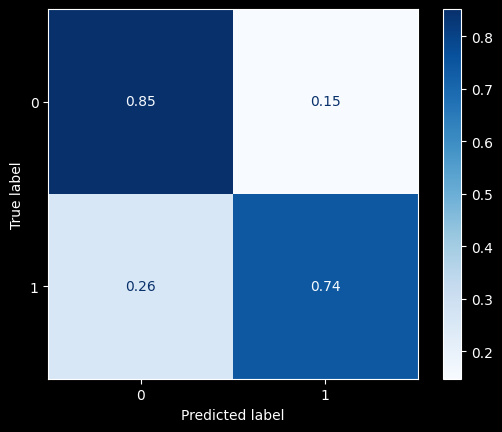

In [34]:
ConfusionMatrixDisplay.from_predictions(
    y_test, probabilities_one_test >= optimal_threshold, normalize='true', colorbar=True, cmap='Blues');

## Conclusion

1.We trained three models (Logistic Regression, LGBMClassifier, Cat Boost Classifier) on the initial sample and balanced them. Balancing was carried out in three different ways: class weighting, oversampling, and understated sampling.

2.Using oversampling and understated sampling, we obtained retrained models, since the test score is much lower than the training score, while the method of weighing classes helped us to get the highest score and the smallest error. According to the confusion matrix, we can correctly identify 77% of outgoing customers and consider 19% of our customers who did not want to leave to be wrong.

3.Depending on the needs of the business, we can change the weights in the error matrix. Having constructed the roc-auc, we see that the optimal threshold at which the difference between TPR and FPR is maximum is 0.54 if the weights of the income from the client and the cost of retaining the client are the same.